In [93]:
# Import all required libraries.
import torch
import glob
import matplotlib.pylab as plt
from torch.utils.data import Dataset
import torch.nn as nn
import torch.optim as optim
from torch.optim.lr_scheduler import ExponentialLR
import numpy as np
from PIL import Image
from torchvision.models import resnet18
from torchvision import transforms, models
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split

In [94]:
# Filter out the warnings.
import warnings
warnings.filterwarnings("ignore")

In [95]:
# Check if CUDA is available.
# If so, assign the device to CUDA.
if torch.cuda.is_available():
    print("CUDA is available on this machine.")
    device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
    print(f"Found CUDA-enabled device: {torch.cuda.get_device_name(0)}")
else:
    print("CUDA is not available on this machine.")

CUDA is available on this machine.
Found CUDA-enabled device: NVIDIA GeForce RTX 2060


In [96]:
class TorchVisionDataset(Dataset):
    '''
    Dataset class for handling the input image data.
    '''
    def __init__(self, data_dic, transform=None):
        # Initialize the file paths and labels from the input data dictionary.
        self.file_paths = data_dic["X"]
        self.labels = data_dic["Y"]
        self.transform = transform

        # Count for corrupted images.
        self.corrupted_count = 0

    def __len__(self):
        '''
        Returns the total number of samples in the dataset.
        '''
        return len(self.file_paths)

    
    def __getitem__(self, idx):
        '''
        Retrieves an image and its corresponding label from the dataset
        based on a provided index location, idx.
        '''
        label = self.labels[idx]
        file_path = self.file_paths[idx]

        try:
            # Open the image file.
            image = Image.open(file_path)

            # Convert RGBA images to RGB.
            if image.mode == 'RGBA':
                image = image.convert('RGB')
            
            # Apply transformations (if specified).
            if self.transform:
                image = self.transform(image)
            return image, label
        
        except Exception as e:
            # Error handling for corrupted images.
            self.corrupted_count += 1
            print(self.corrupted_count)
            return torch.zeros(3, 224, 224), label

In [97]:
# Load image paths and store in an numpyp array, images.
images = glob.glob("../data/*/*/*")
images = np.array(images)

# Load the corresponding labels by splitting the file path on \ delimiter.
# Take the second from last entry in the array as the label.
labels = np.array([f.split("\\")[-2] for f in images])

# Print the length of the images and labels array.
# Print the first entry of the images and labels array.
print(len(images))
print(labels.size)
print(images[0])
print(labels[0])

8000
8000
../data\test\Bridge\018.jpg
Bridge


In [98]:
# Get all unique classes from the label array.
classes = np.unique(labels).flatten()
print(classes)

# Convert labels to integers.
labels_int = np.zeros(labels.size, dtype=np.int64)
print(labels_int.shape)

# Assign integer labels to each class.
for ii, jj in enumerate(classes):
    labels_int[labels == jj] = ii 

['Bridge' 'Commercial' 'Industrial' 'Intersection' 'Landmark' 'Park'
 'Parking' 'Playground' 'Residential' 'Stadium']
(8000,)


In [99]:
# Iterate through each label and print the total sum
# of samples for each.
for ii in range(len(classes)):
    print("Label ", ii, ":", (labels_int == ii).sum())

Label  0 : 800
Label  1 : 800
Label  2 : 800
Label  3 : 800
Label  4 : 800
Label  5 : 800
Label  6 : 800
Label  7 : 800
Label  8 : 800
Label  9 : 800


In [100]:
# Split the dataset into development and test sets.
# Stratification is used to maintain class distribution for both sets.
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
sss.get_n_splits(images, labels_int)
dev_index, test_index = next(sss.split(images, labels_int))

dev_images = images[dev_index]
dev_labels = labels_int[dev_index]

test_images = images[test_index]
test_labels = labels_int[test_index] 

In [101]:
# Split the development set into training and validation sets.
sss2 = StratifiedShuffleSplit(n_splits=10, test_size=0.1, random_state=1)
sss2.get_n_splits(dev_images, dev_labels)
train_index, val_index = next(sss2.split(dev_images, dev_labels))

train_images = images[train_index]
train_labels = labels_int[train_index]

val_images = images[val_index]
val_labels = labels_int[val_index] 


In [102]:
# Print the size of the train set, validation set, and test set.
print("Train set:", len(train_images))
print("Val set:", len(val_images))
print("Test set:", len(test_images))

Train set: 6480
Val set: 720
Test set: 800


In [103]:
# Combine the images and labels into dictionaries for the training, validation, and testing sets.
train_set = {"X": train_images, "Y": train_labels}
val_set = {"X": val_images, "Y": val_labels}
test_set = {"X": test_images, "Y": test_labels}

In [104]:
# Define required transformations.
torchvision_transform = transforms.Compose([transforms.Resize((224,224)),\
    transforms.RandomHorizontalFlip(), transforms.RandomVerticalFlip(),
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

torchvision_transform_test = transforms.Compose([transforms.Resize((224,224)),\
    transforms.ToTensor(),transforms.Normalize(mean=[0.485, 0.456, 0.406],std=[0.229, 0.224, 0.225])])

In [105]:
# Create the training, validation, and testing datasets (with defined transformations)
train_dataset = TorchVisionDataset(train_set, transform=torchvision_transform)
val_dataset = TorchVisionDataset(val_set, transform=torchvision_transform)
test_dataset = TorchVisionDataset(test_set, transform=torchvision_transform_test)

In [106]:
# Create dataloaders for each dataset.
trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=0)
valloader = torch.utils.data.DataLoader(val_dataset, batch_size=32, num_workers=0)
testloader = torch.utils.data.DataLoader(test_dataset, batch_size=32, num_workers=0)

In [107]:
def get_dataset_stats(data_loader):
    '''
    Computes overall statistics on a dataset.
    '''
    mean = 0.
    std = 0.
    nb_samples = 0.
    for data in data_loader:
        data = data[0]  # Get the images to compute the statistics.
        batch_samples = data.size(0)
        data = data.view(batch_samples, data.size(1), -1)
        mean += data.mean(2).sum(0)
        std += data.std(2).sum(0)
        nb_samples += batch_samples

    mean /= nb_samples
    std /= nb_samples
    return mean, std

In [108]:
# Print the mean and standard deviation of the training dataset.
print(get_dataset_stats(trainloader))

(tensor([-0.5162, -0.3514, -0.2517]), tensor([0.6761, 0.6550, 0.6404]))


In [109]:
# Define a batch of data from the dataloader.
train_iterator = iter(trainloader)
train_batch = next(train_iterator)

In [110]:
# Print the size of the batch.
print(train_batch[0].size())
print(train_batch[1].size())

torch.Size([32, 3, 224, 224])
torch.Size([32])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


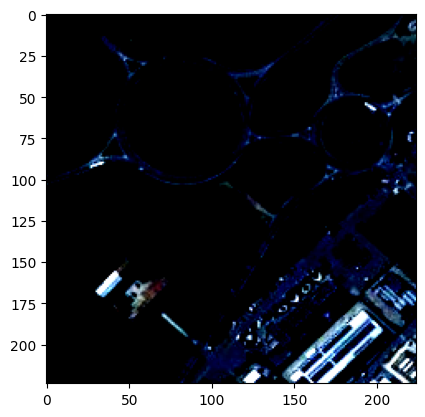

In [111]:
# Show an image from the batch.
plt.figure()
plt.imshow(train_batch[0].numpy()[16].transpose(1,2,0))
plt.show()

In [112]:
class ResNet18(nn.Module):
    '''
    Pretrained CNN model to be used for image classification.
    '''
    def __init__(self, num_classes):
        # Initialize ResNet18 architecture.
        super(ResNet18, self).__init__()
        self.model = models.resnet18(pretrained=True)
        # Modify the fully connected later to output num_classes.
        self.model.fc = nn.Linear(self.model.fc.in_features, num_classes)

    def forward(self, x):
        # Forward pass through the model.
        return self.model(x)

In [113]:
# Initialize the model.
net = ResNet18(len(classes))
net.to(device)

ResNet18(
  (model): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_runn

In [114]:
# Define the loss function, optimizer, and learning rate scheduler.
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0001)
scheduler = ExponentialLR(optimizer, gamma=0.9)

In [115]:
# Define the number of epochs.
nepochs = 20

# Define the path to save the best model.
PATH = './saved_models/resnet18.pth'

# Initialize the best loss value.
best_loss = 1e+20

# Number of epochs to wait before early stopping.
patience = 3  
count = 0

# Create two lists to store training and validation loss values for each epoch.
train_loss_list = []
val_loss_list = []

# Create two lists to store training and validation accuracy values for each epoch.
train_acc_list = []
val_acc_list = []

# Training Loop.
for epoch in range(nepochs):
    train_loss = 0.0
    correct_train = 0
    total_train = 0

    # Set the model to training mode.
    net.train()

    for i, data in enumerate(trainloader, 0):
        # get the inputs; data is a list of [inputs, labels].
        inputs, labels = data[0].to(device), data[1].to(device)

        # Zero the parameter gradients.
        optimizer.zero_grad()

        # Perform the forward pass.
        outputs = net(inputs)
        
        loss = criterion(outputs, labels)

        # Perform the backward pass.
        loss.backward()

        # Perform optimization.
        optimizer.step()

        # Update the training loss.
        train_loss += loss.item()

        # Calculate training accuracy.
        _, predicted_train = torch.max(outputs, 1)
        total_train += labels.size(0)
        correct_train += (predicted_train == labels).sum().item()
    
    # Print the results to the display for the specific epoch.
    print(f'Epoch {epoch + 1}:  train loss: {train_loss / i:.3f},', end=' ')
    train_loss_list.append(train_loss / (i + 1))

    train_accuracy = 100 * correct_train / total_train
    print(f'train accuracy: {train_accuracy:.2f}%,', end=' ')
    train_acc_list.append(train_accuracy)
    
    # Validation stage.
    val_loss = 0
    correct_val = 0
    total_val = 0

    # Set the model to evaluation mode.
    net.eval()

    with torch.no_grad():
        for i, data in enumerate(valloader, 0):
            # get the inputs; data is a list of [inputs, labels].
            inputs, labels = data[0].to(device), data[1].to(device) 
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            
            val_loss += loss.item()

            # Calculate validation accuracy.
            _, predicted_val = torch.max(outputs, 1)
            total_val += labels.size(0)
            correct_val += (predicted_val == labels).sum().item()

        print(f'val loss: {val_loss / (i + 1):.3f},', end=' ')
        val_loss_list.append(val_loss / (i + 1))

        val_accuracy = 100 * correct_val / total_val
        print(f'val accuracy: {val_accuracy:.2f}%')
        val_acc_list.append(val_accuracy)
        
        # Save the best model.
        if val_loss < best_loss:
            print("Saving model")
            torch.save(net.state_dict(), PATH)
            best_loss = val_loss
            count = 0  # Reset count if we found a better model
        else:
            count += 1
            # Early stopping.
            if count >= patience:
                print(f'Early stopping at epoch {epoch + 1}')
                break
        
print('Finished Training')


Epoch 1:  train loss: 0.867, train accuracy: 73.86%, val loss: 0.314, val accuracy: 90.56%
Saving model
Epoch 2:  train loss: 0.282, train accuracy: 91.16%, val loss: 0.218, val accuracy: 93.89%
Saving model
Epoch 3:  train loss: 0.189, train accuracy: 94.21%, val loss: 0.181, val accuracy: 93.75%
Saving model
Epoch 4:  train loss: 0.143, train accuracy: 95.60%, val loss: 0.177, val accuracy: 93.89%
Saving model
Epoch 5:  train loss: 0.113, train accuracy: 96.74%, val loss: 0.167, val accuracy: 94.72%
Saving model
Epoch 6:  train loss: 0.089, train accuracy: 97.53%, val loss: 0.154, val accuracy: 94.44%
Saving model
Epoch 7:  train loss: 0.077, train accuracy: 97.87%, val loss: 0.149, val accuracy: 95.00%
Saving model
Epoch 8:  train loss: 0.057, train accuracy: 98.50%, val loss: 0.141, val accuracy: 95.69%
Saving model
Epoch 9:  train loss: 0.053, train accuracy: 98.64%, val loss: 0.137, val accuracy: 95.42%
Saving model
Epoch 10:  train loss: 0.047, train accuracy: 98.75%, val loss: 

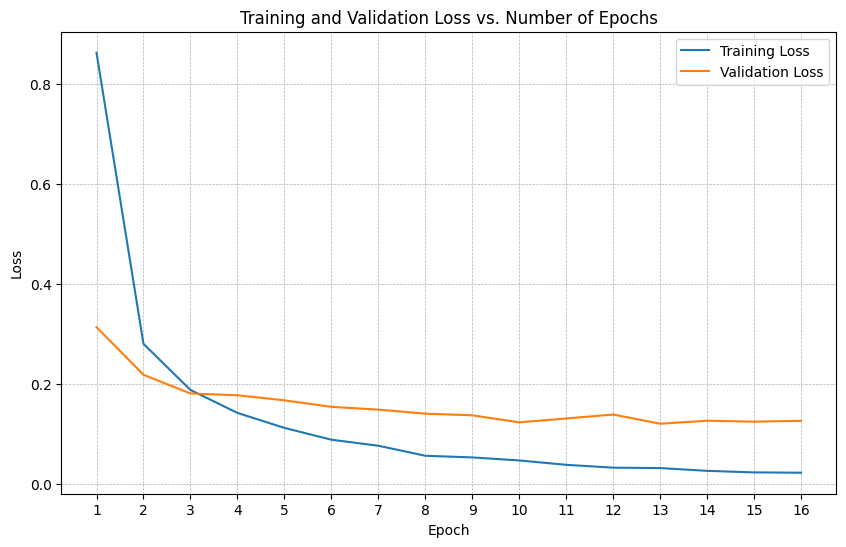

In [116]:
# Graph the train and val loss values over the number of epocse iterations. 
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_loss_list) + 1), train_loss_list, label='Training Loss')
plt.plot(range(1, len(val_loss_list) + 1), val_loss_list, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training and Validation Loss vs. Number of Epochs')
plt.legend()
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.xticks(range(1, len(train_loss_list) + 1))
plt.show()

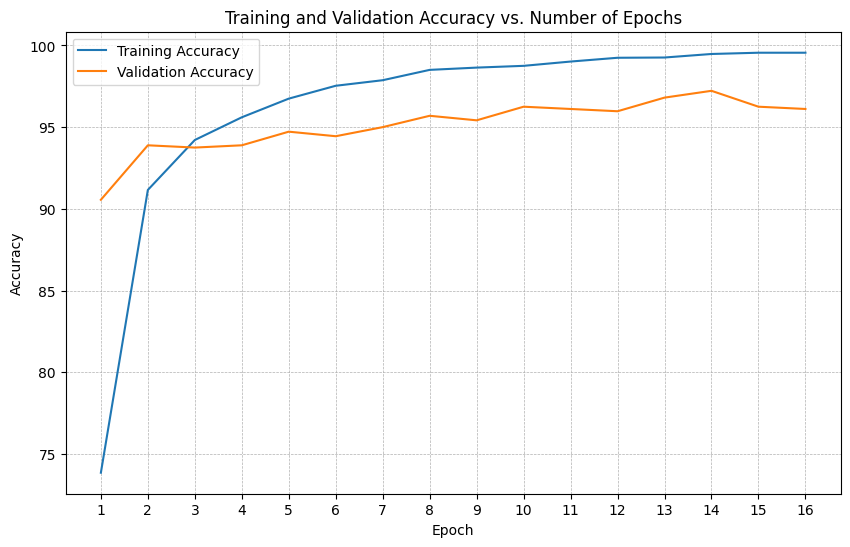

In [117]:
# Plotting accuracy vs. epochs.
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(train_acc_list) + 1), train_acc_list, label='Training Accuracy')
plt.plot(range(1, len(val_acc_list) + 1), val_acc_list, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy vs. Number of Epochs')
plt.legend()
plt.grid(True, which='both', axis='both', linestyle='--', linewidth=0.5)
plt.xticks(range(1, len(train_acc_list) + 1))
plt.show()

In [118]:
# Load the best model.
net = ResNet18(len(classes))
net.load_state_dict(torch.load(PATH))

<All keys matched successfully>

In [119]:
# Evaluate the model on the test set.
class_correct = [0 for _ in range(len(classes))]
class_total = [0 for _ in range(len(classes))]
overall_correct = 0
overall_total = 0

# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network.
        outputs = net(images)

        # The class with the highest energy is what we choose as prediction.
        _, predicted = torch.max(outputs, 1)
        for i in range(len(labels)):
            label = labels[i]
            class_correct[label] += (predicted[i] == label).item()
            class_total[label] += 1
            overall_correct += (predicted[i] == label).item()
            overall_total += 1

# Print the accuracy of the network on the test images.
for i in range(len(classes)):
    accuracy = 100 * class_correct[i] / class_total[i]
    print(f'Accuracy of class {i} - {classes[i]}: {accuracy:.2f} %')

overall_accuracy = 100 * overall_correct / overall_total
print(f'Overall accuracy: {overall_accuracy:.2f} %')


Accuracy of class 0 - Bridge: 98.75 %
Accuracy of class 1 - Commercial: 96.25 %
Accuracy of class 2 - Industrial: 100.00 %
Accuracy of class 3 - Intersection: 97.50 %
Accuracy of class 4 - Landmark: 96.25 %
Accuracy of class 5 - Park: 100.00 %
Accuracy of class 6 - Parking: 100.00 %
Accuracy of class 7 - Playground: 97.50 %
Accuracy of class 8 - Residential: 100.00 %
Accuracy of class 9 - Stadium: 100.00 %
Overall accuracy: 98.62 %


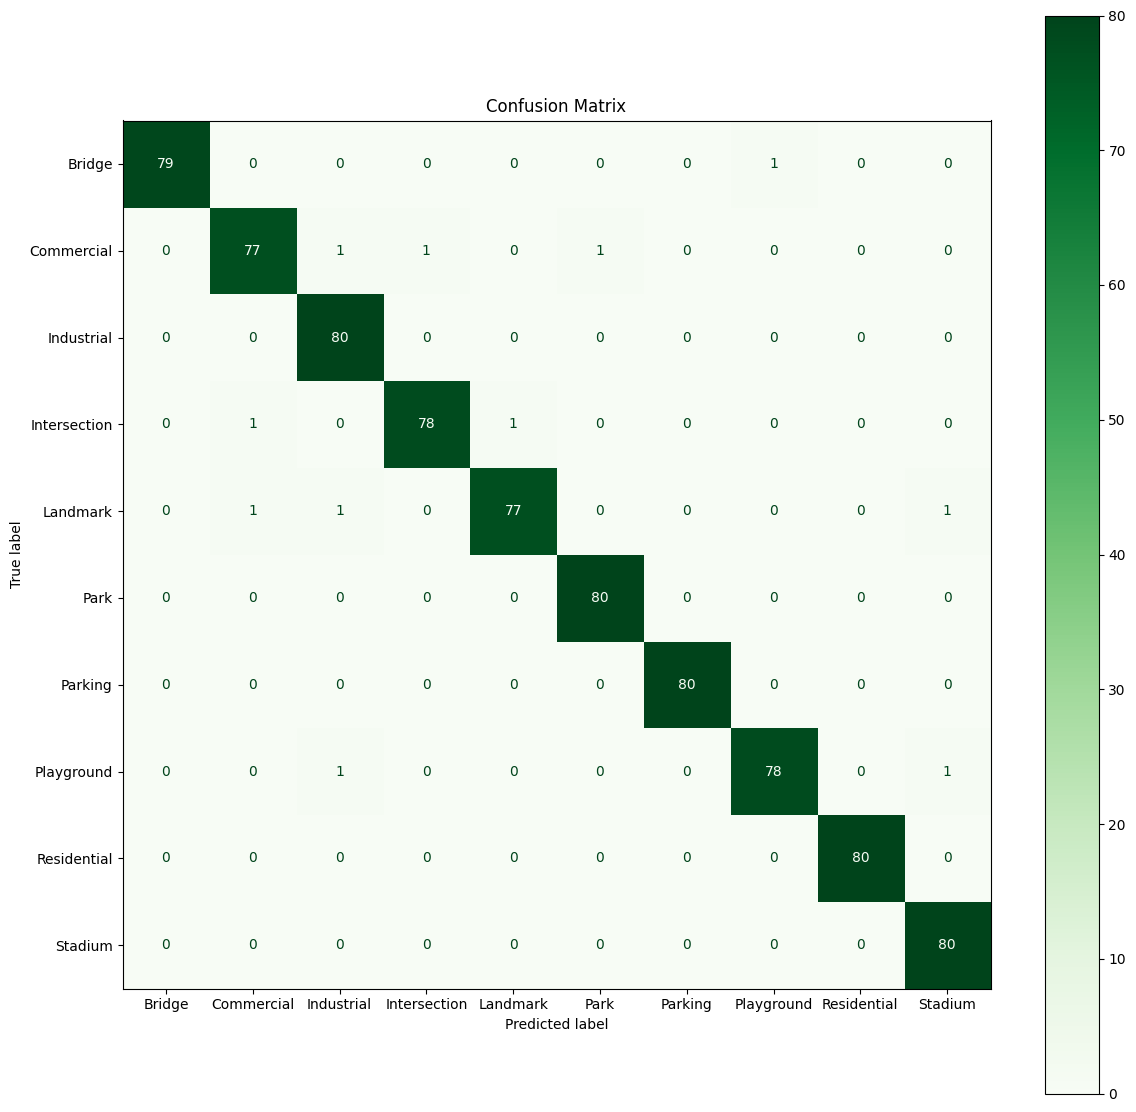

In [123]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, accuracy_score, precision_score, recall_score, f1_score

# Initialize variables to store true labels and predicted labels.
true_labels = []
predicted_labels = []

# Since we're not training, we don't need to calculate the gradients for our outputs.
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # Calculate outputs by running images through the network.
        outputs = net(images)
        # The class with the highest energy is what we choose as prediction.
        _, predicted = torch.max(outputs, 1)
        true_labels.extend(labels.numpy())
        predicted_labels.extend(predicted.numpy())


# Calculate the confusion matrix.
conf_matrix = confusion_matrix(true_labels, predicted_labels)

# Calculate accuracy, precision, recall, and F1 score.
accuracy = accuracy_score(true_labels, predicted_labels)
precision = precision_score(true_labels, predicted_labels, average='weighted')
recall = recall_score(true_labels, predicted_labels, average='weighted')
f1 = f1_score(true_labels, predicted_labels, average='weighted')

# Create a confusion matrix display.
disp = ConfusionMatrixDisplay(confusion_matrix=conf_matrix, display_labels=classes)

# Plot the confusion matrix.
fig, ax = plt.subplots(figsize=(14, 14))
disp.plot(ax=ax, cmap=plt.cm.Greens)
plt.title('Confusion Matrix')
plt.show()

In [128]:
# Display metrics
print(f'Accuracy: {accuracy:.5f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')


Accuracy: 0.98625
Precision: 0.98637
Recall: 0.98625
F1 Score: 0.98623
